# 1. Install PIP's

In [167]:
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


Note: you may need to restart the kernel to use updated packages.


# 2. Import Packages

In [168]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import spacy
import string
import regex as re
from unidecode import unidecode
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 3. Load Data

In [169]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wreangling

### 4.1. Merge Data

In [170]:
df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

### 4.2. Selected Columns Important

In [171]:
selected_columns = ['review_id', 'review_score', 'review_comment_title', 
                    'review_comment_message', 'review_creation_date', 
                    'review_answer_timestamp', 'product_id', 
                    'geolocation_lat', 'geolocation_lng']

full_df = df.loc[:, selected_columns]

### 4.3. Conversion Columns Data in datetime

In [172]:
datetime_columns = ['review_creation_date', 'review_answer_timestamp']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

### 4.5. Drop Duplicates and NA

In [173]:
full_df = full_df.drop_duplicates(subset=['review_id'])
full_df['review_comment_message'] = full_df['review_comment_message'].str.strip()
full_df = full_df.dropna(subset=['review_comment_message'])
full_df = full_df.dropna(subset=['review_score'])

### 4.6. Conversion Column Message in Lower Case

In [174]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.lower()

### 4.7. Removing Punctuation, Exemple (".", "!")

In [175]:
punct = string.punctuation
punct = punct.replace("'","")
full_df['review_comment_message'] = full_df['review_comment_message'].str.translate(str.maketrans(" "," ",punct))

### 4.8. Space removed at the beginning and end of the message

In [176]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.strip()

### 4.9. Removing Emoji

In [177]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
                           u"\U0001F680-\U0001F6FF"  # transporte e símbolos de mapa
                           u"\U0001F1E0-\U0001F1FF"  # bandeiras (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: emoji_pattern.sub(r'', x))

### 4.10. Removing Sites and Blogs

In [178]:
http = r"http\S+|www\.\S+"
pattern = re.compile(r"({})".format(http))
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: pattern.sub(r'', x))

### 4.11. Removing Accentuation

In [179]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: unidecode(x))

In [180]:
nlp = spacy.load('pt_core_news_sm')
def filtrar_tokens(texto):
    doc = nlp(texto)
    tokens_filtrados = []
    for token in doc:
        if token.text.lower() == 'nao':
            tokens_filtrados.append(token.text)
        elif token.pos_ in ['ADJ', 'VERB', 'NOUN', 'ADV']:
            tokens_filtrados.append(token.text)
    return ' '.join(tokens_filtrados)

full_df['review_comment_message'] = full_df['review_comment_message'].apply(filtrar_tokens)

In [181]:
df_pause = full_df.copy()

### 4.12. Lematization

In [182]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

### 4.13. Remove Numbers

In [183]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'\d+', '', x))

### 4.4. Remove Space Blank Excessive and Remove Broke Line

In [184]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.replace('\n', ' ')
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
full_df = full_df[full_df['review_comment_message'].str.strip() != '']
full_df = full_df[~full_df['review_comment_message'].str.contains('nan')]

### 4.14. Join Word "Nao" with Next Word

In [38]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'nao\s+(\w+)', r'nao\1', x))

In [185]:
full_df.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng
0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,nao testar produto ainda vir correto bom condicoes apenas caixa vir bem amassar danificar ficara chato tratar presente,2017-10-11,2017-10-12 03:43:48,87285b34884572647811a353c7ac498a,-23.680114,-46.452454
207,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,muito bom produto,2018-08-08,2018-08-08 18:37:50,595fac2a385ac33a80bd5114aec74eb8,-19.810119,-43.984727
448,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,produto exatamente esperar descrito site chegar bem antes data prever,2017-12-03,2017-12-05 19:21:58,d0b61bfb1de832b15ba9d266ca96e5b0,-19.840168,-43.923299
620,e07549ef5311abcc92ba1784b093fb56,2,NaN,fiquei tristir ter atendir,2017-05-13,2017-05-13 20:25:42,a1804276d9941ac0733cfd409f5206eb,-23.536892,-46.713111
1468,15898b543726a832d4137fbef5d1d00e,1,NaN,aguardar retorno loja,2017-05-30,2017-05-30 23:13:47,08574b074924071f4e201e151b152b4e,-20.297537,-40.400869


# 5. Previus Analyze

In [96]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    for name in metadata['Column'].value_counts().index:
        metadata.loc[metadata['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,review_id,object,0,39901,a54f0611adc9ed256b57ede6b6eb5114,15.28
1,review_score,int64,0,5,4,1.90
2,review_comment_title,object,30243,4064,NaN,10.00
3,review_comment_message,object,0,31363,testar produto ainda vir correto bom condicoe apenas caixa vir bem amassar danificar ficarar chato tratar presente,14.03
4,review_creation_date,object,0,618,2017-10-11 00:00:00,8.78
5,review_answer_timestamp,object,0,39875,2017-10-12 03:43:48,15.28
6,product_id,object,0,17919,87285b34884572647811a353c7ac498a,13.17
7,geolocation_lat,float64,0,1891,-23.680114,8.82
8,geolocation_lng,float64,0,1891,-46.452454,8.82


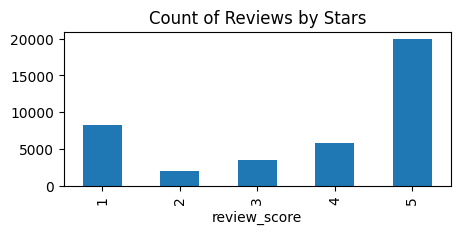

In [186]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [187]:
example = full_df['review_comment_message'].iloc[4]
print(example)

aguardar retorno loja


# 6. Training Model

### 6.1. Separeting Dataframe Training and Dataframe Test After Training

In [205]:
# Amostra os dados para df_train
df_train = full_df.sample(frac=0.95, random_state=45, ignore_index=True)

# Seleciona as linhas que não estão presentes em df_train para df_remaining
df_remaining = full_df.loc[~full_df.index.isin(df_train.index)].reset_index(drop=True)

In [63]:
df_positive = df_train[df_train['review_score'] >= 3]  # considerando 3, 4 e 5 como positivos
df_negative = df_train[df_train['review_score'] < 3]  # considerando 1 e 2 como negativos

# Igualar o número de amostras positivas e negativas
df_positive_equal = df_positive.sample(n=len(df_negative), random_state=42)

# Verificar o número de amostras após o balanceamento
print("Número de amostras positivas (após balanceamento):", len(df_positive_equal))

# Concatenar os DataFrames positivo e negativo igualizados
df_balanced = pd.concat([df_positive_equal, df_negative], ignore_index=True)

# Verificar novamente o número de amostras positivas e negativas no DataFrame balanceado
print("Número de amostras positivas no DataFrame balanceado:", len(df_balanced[df_balanced['review_score'] >= 3]))
print("Número de amostras negativas no DataFrame balanceado:", len(df_balanced[df_balanced['review_score'] < 3]))

Número de amostras positivas (após balanceamento): 9752
Número de amostras positivas no DataFrame balanceado: 9752
Número de amostras negativas no DataFrame balanceado: 9752


### 6.2. Classifier Review Score Negative with 0 (Review 1 or 2) and Positive with 1 (Review 3,4 or 5)

In [206]:
df_train['sentiment'] = df_train['review_score'].apply(lambda x: 0 if x in [1,2,3] else 1)

In [207]:
df_train.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,sentiment
0,69de58ba58203563d10af192cadb5b2d,5,NaN,ameir produto exatamente descrito anuncio perfeito bem trabalho detalhe enfim ameir,2018-03-08,2018-03-09 15:31:56,f7b39dca4a425dcfd4a8b0b0aac4b7c0,-23.611654,-46.632588,1
1,2ce0837059ff2b0ae828b179978cd8db,5,NaN,excelente parceiro,2017-12-30,2018-01-08 14:50:03,2947c2678aab0b7bfc86dd062d9c3318,-22.549033,-43.210095,1
2,cb04972fa9fedc59b149c76610979502,5,NaN,estetoscopio otimar qualidade entregar muito rapir,2017-11-28,2017-11-29 11:48:39,5edb58b97a719cf98b2a76f48e723f05,-22.428726,-42.975568,1
3,503ee23189da157ab530baf0b650ab30,1,NaN,produto entregar por conjunto comprar conjunto gostar saber quando receberar segundo conjunto ja segundo problema consecutivo ter voce,2018-04-12,2018-04-12 19:48:54,4debd977b5bc245487ec61b7961b16e3,-23.538779,-46.536486,0
4,c1e04536dd9ca9ded2a1b2e30231d932,5,NaN,produto Entrege antes prazo otimo estar bem atendir quando precisar tirar duvida,2017-02-21,2017-02-22 00:48:06,ca9bcd697674a4d0eeb84be9c533b9d2,-21.808017,-49.620649,1


### 6.3. Selecting Columns Necessary for Training

In [208]:
selected_columns = ['review_comment_message', 'sentiment']
df_classification = df_train.loc[:, selected_columns]

In [209]:
df_classification.head(5)

,review_comment_message,sentiment
0,ameir produto exatamente descrito anuncio perfeito bem trabalho detalhe enfim ameir,1
1,excelente parceiro,1
2,estetoscopio otimar qualidade entregar muito rapir,1
3,produto entregar por conjunto comprar conjunto gostar saber quando receberar segundo conjunto ja segundo problema consecutivo ter voce,0
4,produto Entrege antes prazo otimo estar bem atendir quando precisar tirar duvida,1


### 6.4. Divising Dataframe Between Train and Test

In [210]:
comment_train, comment_test, sentiment_train, sentiment_test = train_test_split(
                                                                                df_classification['review_comment_message'],
                                                                                df_classification['sentiment'], 
                                                                                test_size=0.2,
                                                                                random_state=24)

### 6.5. Inicializing Training IA

In [211]:
vectorizer = TfidfVectorizer()

In [212]:
ctmTr = vectorizer.fit_transform(comment_train)
comment_test_dtm = vectorizer.transform(comment_test)

In [213]:
smote = SMOTE(random_state=42)
ctmTr_resampled, sentiment_train_resampled = smote.fit_resample(ctmTr, sentiment_train)

In [214]:
normalization = preprocessing.StandardScaler(with_mean=False)

In [215]:
normalization.fit(ctmTr_resampled)
X = normalization.transform(ctmTr_resampled)

In [216]:
analyze_sentiment = MLPClassifier(hidden_layer_sizes=(100,50,50),
                                   activation='relu',
                                   solver='sgd',
                                   max_iter=100,
                                   early_stopping=True,
                                   n_iter_no_change=10,
                                   verbose=True)

history = analyze_sentiment.fit(X, sentiment_train_resampled)

Iteration 1, loss = 0.67415337
Validation score: 0.734746
Iteration 2, loss = 0.54041139
Validation score: 0.802144
Iteration 3, loss = 0.38096019
Validation score: 0.837886
Iteration 4, loss = 0.26471863
Validation score: 0.857799
Iteration 5, loss = 0.20728935
Validation score: 0.872862
Iteration 6, loss = 0.17812342
Validation score: 0.875415
Iteration 7, loss = 0.16024942
Validation score: 0.875925
Iteration 8, loss = 0.14775485
Validation score: 0.878223
Iteration 9, loss = 0.13849373
Validation score: 0.879500
Iteration 10, loss = 0.13103024
Validation score: 0.880776
Iteration 11, loss = 0.12461706
Validation score: 0.880010
Iteration 12, loss = 0.11943234
Validation score: 0.879755
Iteration 13, loss = 0.11496373
Validation score: 0.879755
Iteration 14, loss = 0.11081298
Validation score: 0.880776
Iteration 15, loss = 0.10717365
Validation score: 0.879244
Iteration 16, loss = 0.10405007
Validation score: 0.880776
Iteration 17, loss = 0.10109682
Validation score: 0.879500
Iterat

# 7. Analyze Performance IA

### 7.1. Score

In [217]:
X_test = normalization.transform(comment_test_dtm)
analyze_sentiment.score(X_test,sentiment_test)

0.8464514407684098

### 7.2. Graph Loss During Training

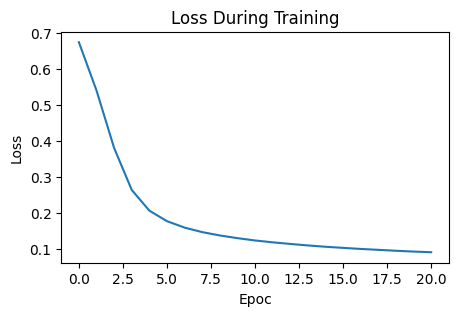

In [218]:
plt.figure(figsize=(5, 3))
plt.plot(history.loss_curve_)
plt.title('Loss During Training')
plt.xlabel('Epoc')
plt.ylabel('Loss')
plt.show()

### 7.3. Confusion Matrix

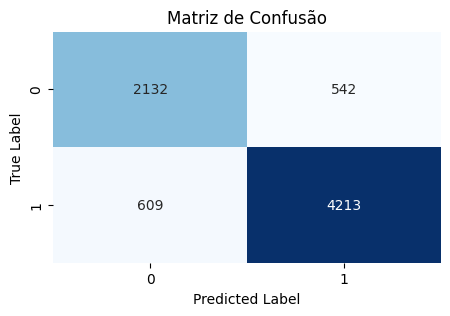

In [219]:
# Fazer previsões no conjunto de teste
predictions = analyze_sentiment.predict(X_test)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(sentiment_test, predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 7.4. Curve ROC

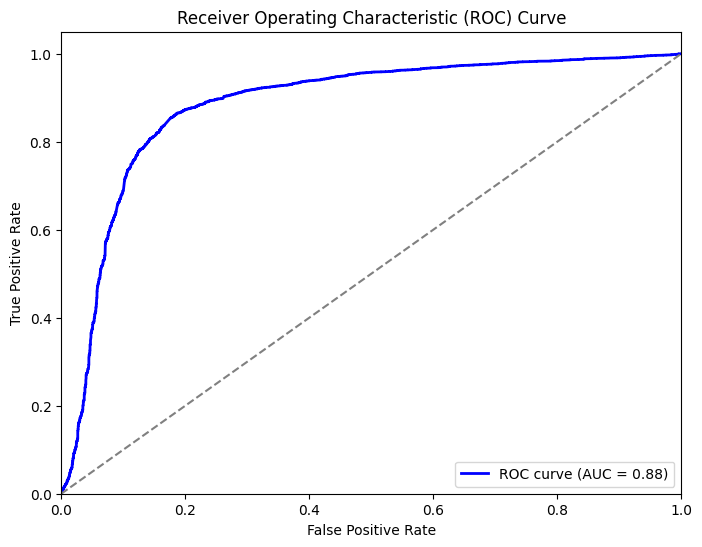

In [220]:
# Calcular as probabilidades previstas para a classe positiva
probas_pred = analyze_sentiment.predict_proba(X_test)[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(sentiment_test, probas_pred)

# Calcular a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 8. Test and Deploy IA

In [221]:
# Ajustar configurações para mostrar o texto completo
pd.set_option('display.max_colwidth', None)

texto_teste_vetorizado = vectorizer.transform(df_remaining['review_comment_message'])
texto_teste_normalizado = normalization.transform(texto_teste_vetorizado)
sentimento_predito = analyze_sentiment.predict(texto_teste_normalizado)

df_remaining['sentimento_predito'] = sentimento_predito

df_remaining['sentimento_predito'] = df_remaining['sentimento_predito'].replace({0: 'negativo', 1: 'positivo'})

print(df_remaining[['review_comment_message', 'review_score', 'sentimento_predito']])

df_remaining[['review_id','review_comment_message', 'review_score', 'sentimento_predito']].to_csv('dados_processados.csv', index=False)


                                                               review_comment_message  \
0                                                                entregar antes prazo   
1      satisfeito recebir bem antes prazo estimar falta nao acompanhar cartucho tinta   
2                                                 gostar compr ficar muito legal moto   
3                                                                     bom atendimento   
4                         indico produto altar qualidade recebir antes prazo combinar   
...                                                                               ...   
39353                     otimo comprar site mercadoria chegar antes prazo determinar   
39354                             nao mini cajon Shaker chocalho imitar cajon pessimo   
39355                                                         pecar vir rachar bem rs   
39356                                                            entregar antes prazo   
39357                

In [77]:
from collections import Counter

# Filtrar mensagens positivas e negativas
mensagens_positivas = df_remaining[df_remaining['sentimento_predito'] == 'positivo']['review_comment_message']
mensagens_negativas = df_remaining[df_remaining['sentimento_predito'] == 'negativo']['review_comment_message']

# Função para contar palavras mais comuns
def contar_palavras(mensagens):
    todas_mensagens = ' '.join(mensagens)
    palavras = todas_mensagens.split()
    contagem_palavras = Counter(palavras)
    return contagem_palavras.most_common(10)

# Contar palavras mais comuns para mensagens positivas
print("Palavras mais comuns em mensagens positivas:")
print(contar_palavras(mensagens_positivas))

# Contar palavras mais comuns para mensagens negativas
print("\nPalavras mais comuns em mensagens negativas:")
print(contar_palavras(mensagens_negativas))

KeyError: 'sentimento_predito'

## division

In [ ]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Criar o modelo MLPClassifier
mlp = MLPClassifier(max_iter=100)

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)

# Treinar o modelo usando a pesquisa em grade
grid_search.fit(X, sentiment_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o desempenho do modelo
print("Acurácia da melhor configuração no conjunto de validação:")
print(grid_search.best_score_)